# Module 4 Final Project: Deep Learning to Classify Skin Cancer Types

For this module project, I will attempt to use deep learning to classify images across 7 different skin cancer types: 

* nv: Melanocytic nevi -- benign neoplasms 
* mel: Melanoma  -- malignant neoplasm
* bkl: "Benign keratosis" -- a generic class
* bcc: Basal cell carcinoma -- a common variant of epithelial skin cancer
* akiec: Actinic Keratoses (Solar Keratoses) and intraepithelial Carcinoma (Bowen’s disease) -- common non-invasive variants
* vasc: Vascular skin lesions 
* df: Dermatofibroma is a benign skin lesion 

To do this, I employed the help of a convolution neural net or CNN. A CNN is different from your run-of-the-mill neural net in that it does not flatten to just the pixels. Rather, it uses a "filter" to figure out the edges and other important features of the images all while not making a computational intensive scan of a multi-dimensional object.

## Import Necessary Libraries

In [1]:
import os # For sorting file paths
import pandas as pd # For dataframe manipulation
import numpy as np # For math related manipulation
import glob 
from sklearn.model_selection import train_test_split # For train-test splitting
import seaborn as sns # For visualization
sns.set(color_codes = True)
from glob import glob
import shutil
from PIL import Image # Pillow for Image insertion into the dataset
import matplotlib.pyplot as plt # For visualization
%matplotlib inline

In [2]:
os.listdir('input')

['hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'hmnist_8_8_RGB.csv',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv']

In [3]:
input_dir = os.path.join('input')

In [4]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
image_id_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('input','*', '*.jpg'))} # For later use when showing the melanomas

## Some PreProcessing Work: Making Directories, Splitting into Validation and Training Sets with Unique Images, etc.

In [6]:
train = os.path.join('train')
os.mkdir(train)

validation = os.path.join('validation')
os.mkdir(validation)

In [7]:
for file in train, validation:
    for key in lesion_type_dict:
        key = os.path.join(file, key)
        os.mkdir(key)

In [8]:
metadata = pd.read_csv('input/HAM10000_metadata.csv')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [9]:
image_count_df = metadata.groupby('lesion_id').count()
unique_image_df = image_count_df[image_count_df['image_id'] == 1]
unique_image_df.reset_index(inplace=True)
unique_image_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [10]:
def identifies_duplicates(x):
    unique_list = list(unique_image_df['lesion_id'])
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

In [11]:
# Add column to metadata to get information on duplicates, starting with lesion_id
# for our previous function to be applied to
metadata['duplicates'] = metadata['lesion_id']

# Apply the funciton to the new column
metadata['duplicates'] = metadata['duplicates'].apply(identifies_duplicates)
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [12]:
metadata['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [13]:
unique_meta_df = metadata[metadata['duplicates'] == 'no_duplicates'] 
unique_meta_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,no_duplicates
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,no_duplicates
20,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,no_duplicates
33,HAM_0005612,ISIC_0024981,bkl,histo,80.0,male,scalp,no_duplicates
34,HAM_0005388,ISIC_0027815,bkl,histo,80.0,male,chest,no_duplicates
...,...,...,...,...,...,...,...,...
9988,HAM_0001036,ISIC_0027588,akiec,histo,50.0,female,face,no_duplicates
9990,HAM_0004462,ISIC_0027334,akiec,histo,45.0,male,trunk,no_duplicates
9991,HAM_0001152,ISIC_0030133,akiec,histo,65.0,male,face,no_duplicates
10001,HAM_0000020,ISIC_0031922,akiec,histo,60.0,female,face,no_duplicates


In [14]:
# Create a validation dataframe from the unique images
lesion_stats = unique_meta_df['dx']

# Test-train split on the unique images from the lesion stats
_, validation_df = train_test_split(unique_meta_df, test_size=0.2, random_state=101, stratify=lesion_stats)

# Run a validation that the metadata that has no duplicates is the same as the unique metadata shape
print(metadata['duplicates'].value_counts()[0]==unique_meta_df.shape[0]) # Should be evaluated to True
validation_df.shape

True


(1103, 8)

In [15]:
validation_df['dx'].value_counts()

nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

In [16]:
def identifies_validation_images(x):
    validation_list = list(validation_df['image_id'])
    if x in validation_list:
        return 'validation'
    else:
        return 'train'

In [17]:
# Add column to metadata to get information on duplicates, starting with lesion_id
# for our previous function to be applied to
metadata['val/train'] = metadata['image_id']

# Apply the funciton to the new column
metadata['val/train'] = metadata['val/train'].apply(identifies_validation_images)
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates,val/train
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates,train


In [18]:
train_df = metadata[metadata['val/train'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates,val/train
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates,train


In [19]:
print(len(train_df))
print(len(validation_df))

8912
1103


In [20]:
train_df['dx'].value_counts() # Heavy class imbalance like in the validation set

nv       5822
mel      1067
bkl      1011
bcc       479
akiec     297
vasc      129
df        107
Name: dx, dtype: int64

## Exploring the Data: Univariate EDA

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'Diagnostic Test: Distribution Plot')

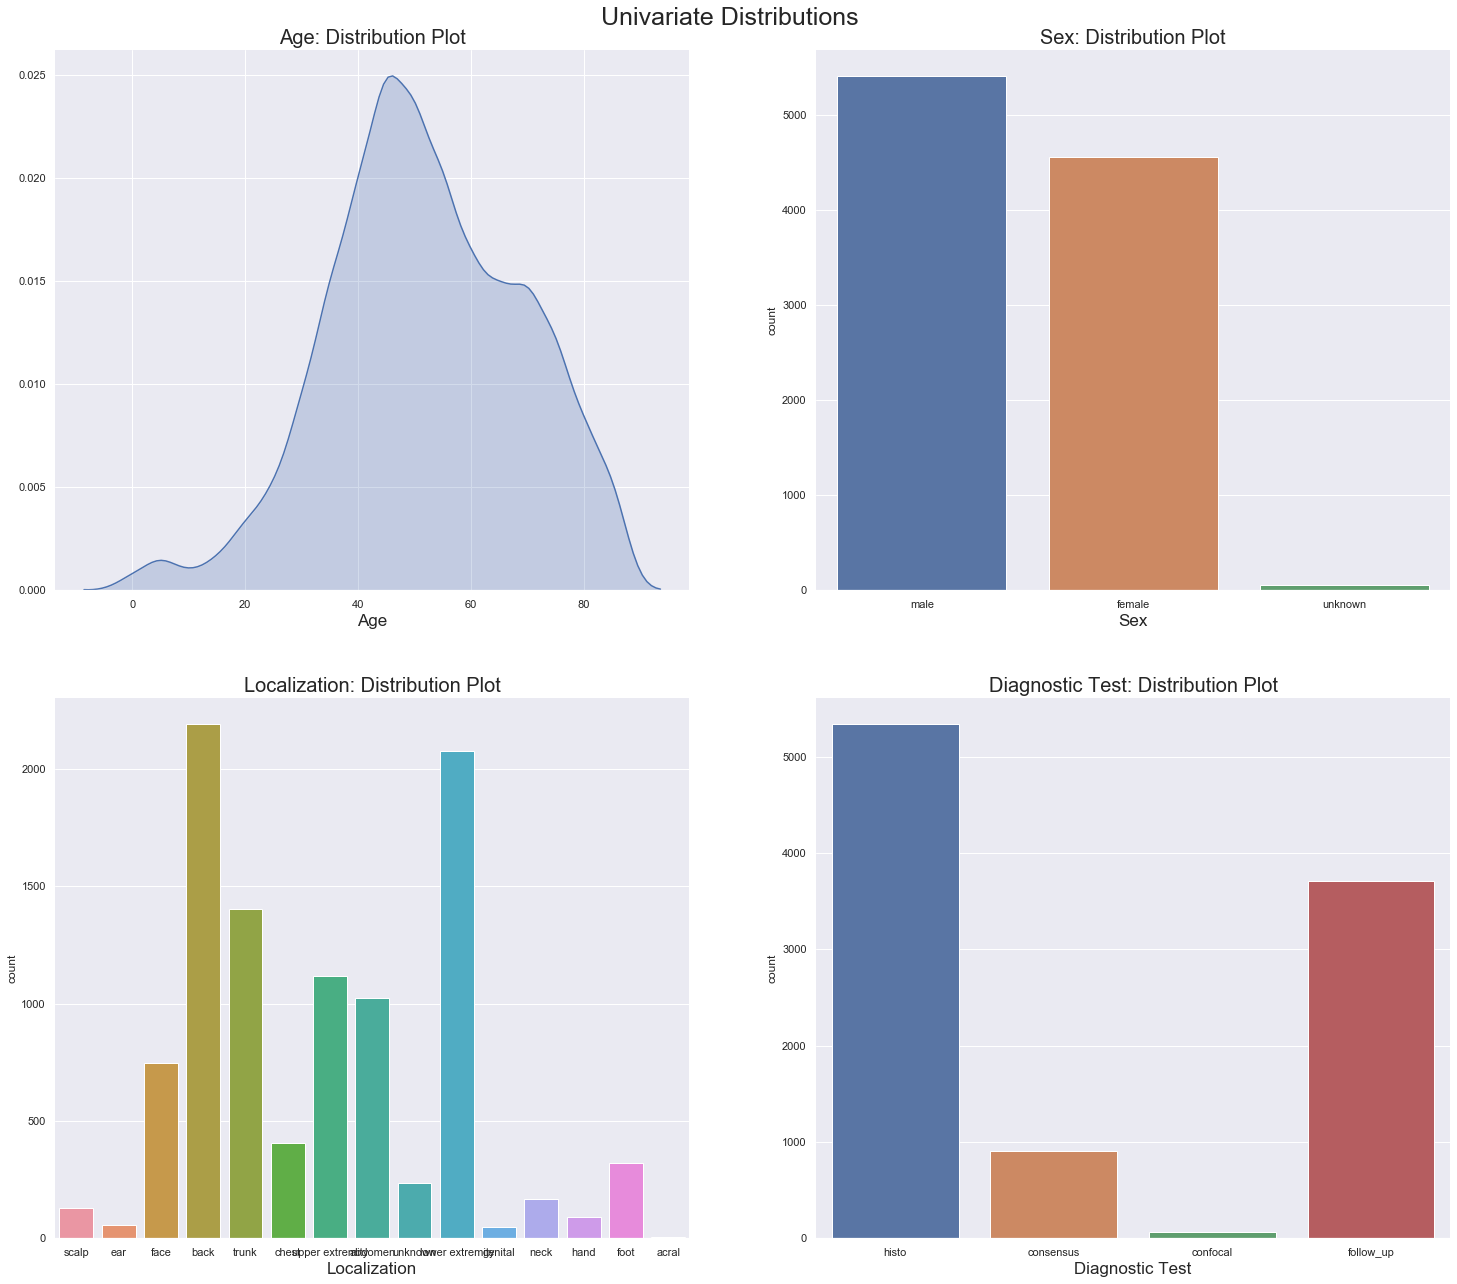

In [21]:
# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(25, 20))
sns.despine(left=True)

plt.subplots_adjust(top=0.95)
f.suptitle('Univariate Distributions', fontsize=25)

# Age distribution
sns.kdeplot(metadata["age"], legend = False, shade = True, ax=axes[0, 0])
axes[0,0].set_xlabel("Age", fontsize=17)
axes[0,0].set_title("Age: Distribution Plot", fontsize=20)

# Sex distribution
sns.countplot(x = "sex", data = metadata, ax=axes[0, 1])
axes[0,1].set_xlabel("Sex", fontsize=17)
axes[0,1].set_title("Sex: Distribution Plot", fontsize=20)

# Localization
sns.countplot(x = "localization", data = metadata, ax=axes[1,0])
axes[1,0].set_xlabel("Localization", fontsize=17)
axes[1,0].set_title("Localization: Distribution Plot", fontsize=20)

# Diagnostic test type
sns.countplot(x = "dx_type", data = metadata, ax=axes[1,1])
axes[1,1].set_xlabel("Diagnostic Test", fontsize=17)
axes[1,1].set_title("Diagnostic Test: Distribution Plot", fontsize=20)

## Exploring the Data: Bivariate EDA

Text(0.5, 1.0, 'Age v. Lesion Type Boxplot')

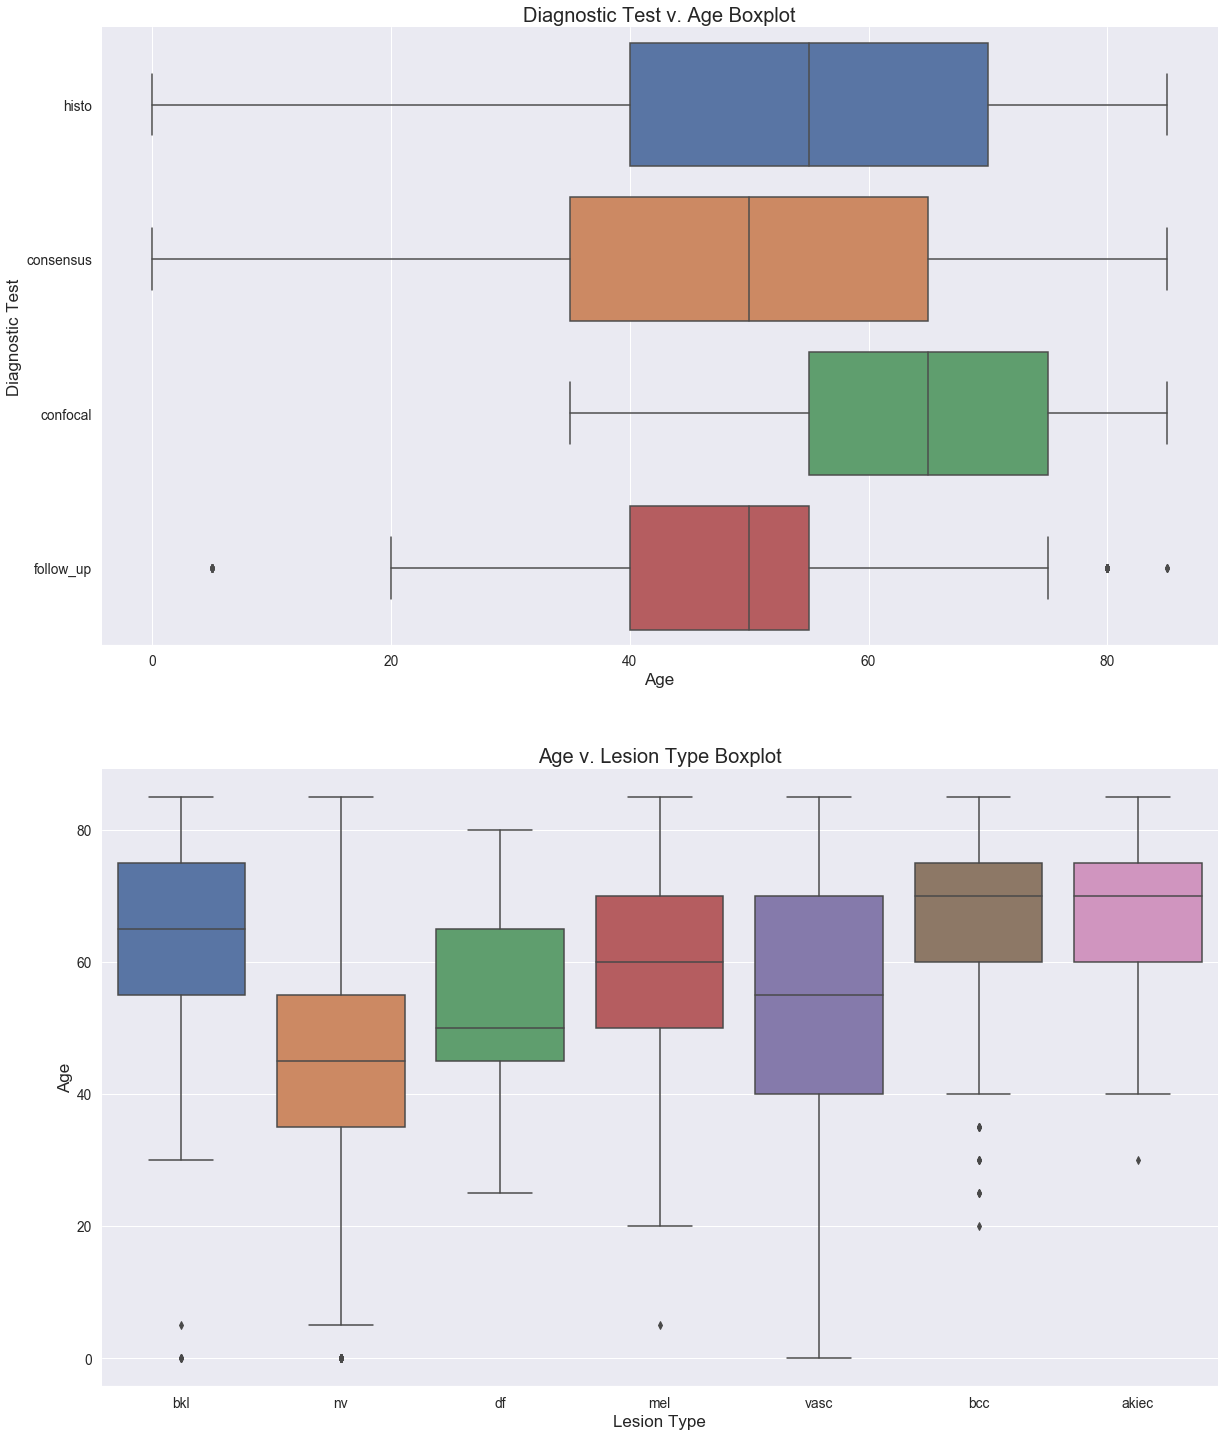

In [22]:
sns.set(font_scale = 1.25)

# Set up the matplotlib figure
f, axes = plt.subplots(2, 1, figsize=(20, 25))
sns.despine(left=True)

# Gender distribution
sns.boxplot(x = "age", y = "dx_type", data = metadata, ax=axes[0])
axes[0].set_xlabel("Age", fontsize=17)
axes[0].set_ylabel("Diagnostic Test", fontsize=17)
axes[0].set_title("Diagnostic Test v. Age Boxplot", fontsize=20)

# Lesion distribution
sns.boxplot(x = "dx", y = "age", data = metadata, ax=axes[1])
axes[1].set_xlabel("Lesion Type", fontsize=17)
axes[1].set_ylabel("Age", fontsize=17)
axes[1].set_title("Age v. Lesion Type Boxplot", fontsize=20)

In [23]:
# Put the images in the dataset so that we can show how each skin cancer looks, below

metadata['path'] = metadata['image_id'].map(image_id_path_dict.get)
metadata['image'] = metadata['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

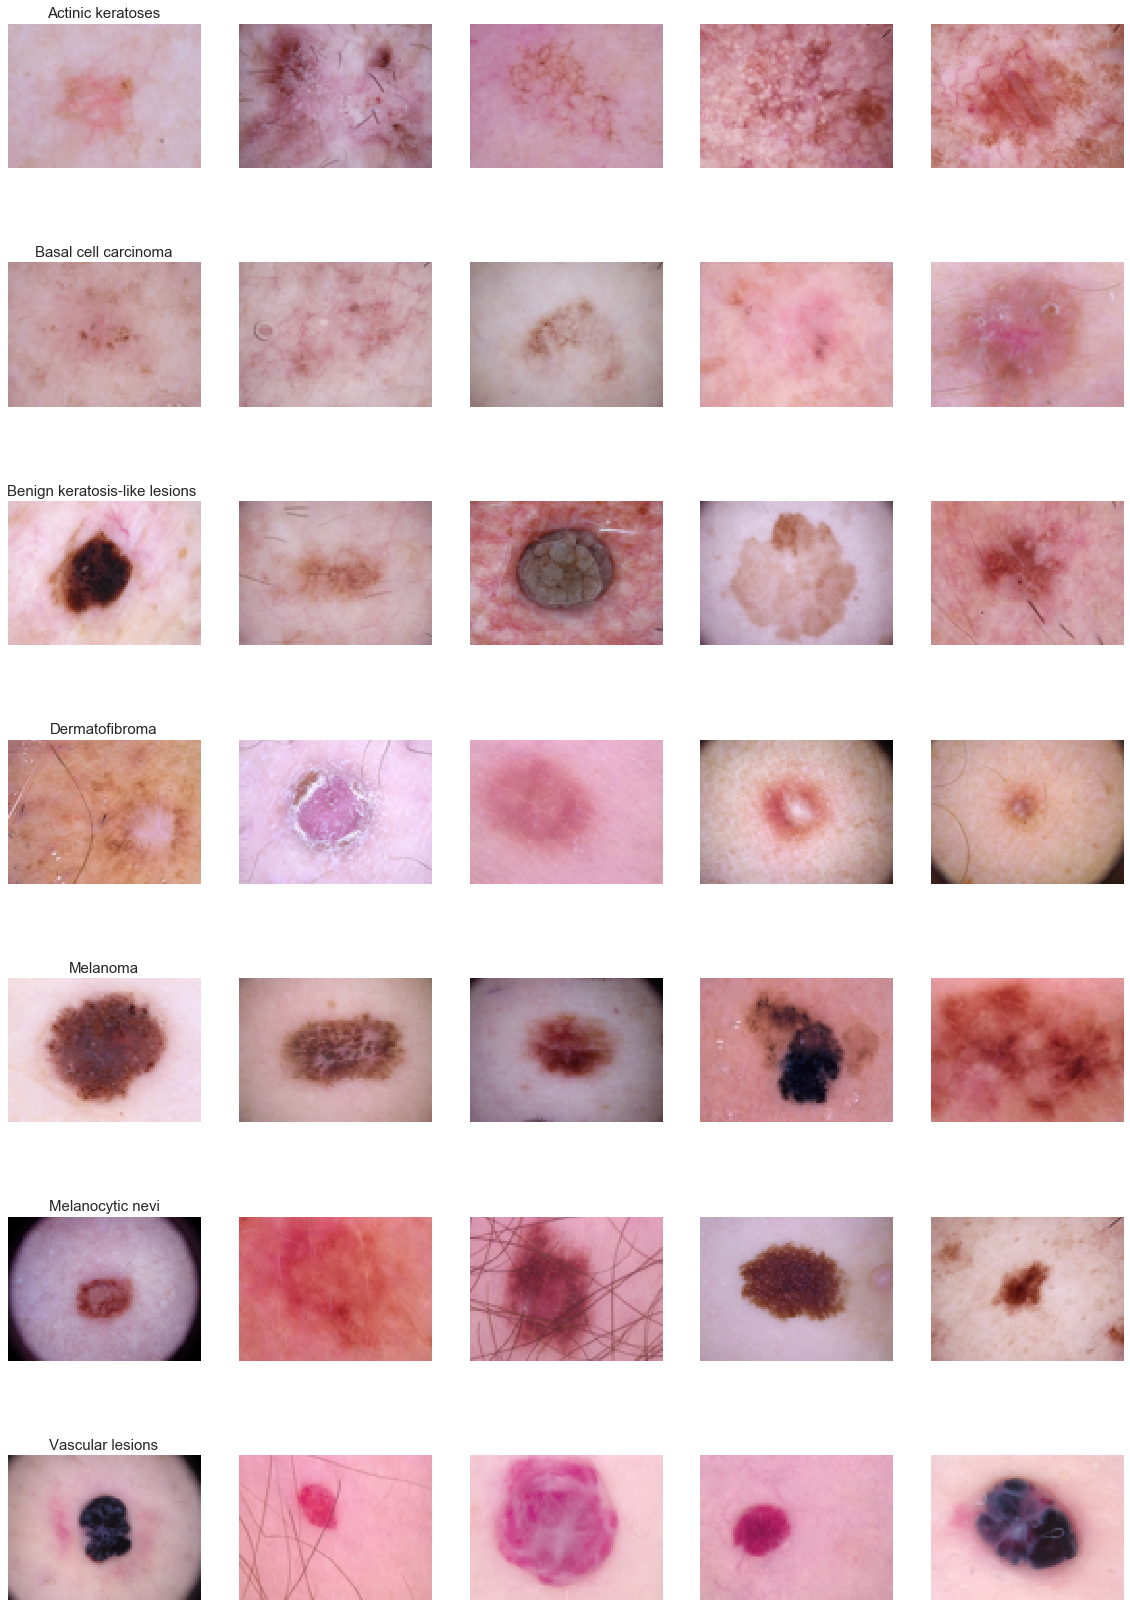

In [24]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (20, 30))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         metadata.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(lesion_type_dict[type_name])
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('sample_skin_lesions.png', dpi=300)

In [25]:
metadata['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [26]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates,val/train,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates,train,input/HAM10000_images_part_1/ISIC_0027419.jpg,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates,train,input/HAM10000_images_part_1/ISIC_0025030.jpg,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates,train,input/HAM10000_images_part_1/ISIC_0026769.jpg,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates,train,input/HAM10000_images_part_1/ISIC_0025661.jpg,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates,train,input/HAM10000_images_part_2/ISIC_0031633.jpg,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


In [27]:
train_df['dx'].value_counts()

nv       5822
mel      1067
bkl      1011
bcc       479
akiec     297
vasc      129
df        107
Name: dx, dtype: int64

In [29]:
metadata.set_index('image_id', inplace=True)

In [30]:
metadata = metadata.reset_index()
metadata.head()

,image_id,lesion_id,dx,dx_type,age,sex,localization,duplicates,val/train,path,image
0,ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,has_duplicates,train,input/HAM10000_images_part_1/ISIC_0027419.jpg,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,has_duplicates,train,input/HAM10000_images_part_1/ISIC_0025030.jpg,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,has_duplicates,train,input/HAM10000_images_part_1/ISIC_0026769.jpg,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,has_duplicates,train,input/HAM10000_images_part_1/ISIC_0025661.jpg,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,has_duplicates,train,input/HAM10000_images_part_2/ISIC_0031633.jpg,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


In [31]:
metadata = metadata.drop(columns=['image'])
metadata.head()

,image_id,lesion_id,dx,dx_type,age,sex,localization,duplicates,val/train,path
0,ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,has_duplicates,train,input/HAM10000_images_part_1/ISIC_0027419.jpg
1,ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,has_duplicates,train,input/HAM10000_images_part_1/ISIC_0025030.jpg
2,ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,has_duplicates,train,input/HAM10000_images_part_1/ISIC_0026769.jpg
3,ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,has_duplicates,train,input/HAM10000_images_part_1/ISIC_0025661.jpg
4,ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,has_duplicates,train,input/HAM10000_images_part_2/ISIC_0031633.jpg


In [32]:
metadata = metadata.set_index('image_id')

In [33]:
images_part_1 = os.listdir('input/HAM10000_images_part_1')
images_part_2 = os.listdir('input/HAM10000_images_part_2')


train_ids_list = list(train_df['image_id'])
validation_ids_list = list(validation_df['image_id'])

In [34]:
for image in train_ids_list:
    
    file_name = image + '.jpg'
    label = metadata.loc[image,'dx']
    
    if file_name in images_part_1:
        src = os.path.join('input/ham10000_images_part_1', file_name)
        dst = os.path.join(train, label, file_name)
        shutil.copyfile(src, dst)

    if file_name in images_part_2:
        src = os.path.join('input/ham10000_images_part_2', file_name)
        dst = os.path.join(train, label, file_name)
        shutil.copyfile(src, dst)

            

In [35]:
for image in validation_ids_list:
    
    file_name = image + '.jpg'
    cell_type = metadata.loc[image,'dx']
    
    if file_name in images_part_1:
        source = os.path.join('input/HAM10000_images_part_1', file_name)
        destination = os.path.join(validation, cell_type, file_name)
        shutil.copyfile(source, destination)
        
    if file_name in images_part_2:
        source = os.path.join('input/HAM10000_images_part_2', file_name)
        destination = os.path.join(validation, cell_type, file_name)
        shutil.copyfile(source, destination)

## Prepping for Modeling

In [117]:
from keras import models, layers, optimizers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

The data contains this csv file that has the RBG transformations of each picture. This might be useful if I can't get any resizing to work. Here's a preview of this dataset before I jump into some of the generator types.

In [37]:
rbg = pd.read_csv('input/hmnist_28_28_RGB.csv', header=0)
featured_columns = rbg.columns[:-1]
featured_columns
rbg = rbg.drop(rbg.index[0])

In [38]:
rbg.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
5,8,1,3,19,5,10,26,8,13,34,...,12,3,7,5,0,1,4,0,0,2


In [241]:
# Made train and validation data generators for use when we try transfer learning

train_generator = ImageDataGenerator(rescale=1./255,
                                     shear_range=0.2,
                                     zoom_range=0.2).flow_from_directory(
                    train,
                    target_size=(224, 224),
                    batch_size=8912,
                    class_mode='binary')



validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                    validation,
                    target_size=(224, 224),
                    batch_size=1103,
                    class_mode='binary')

Found 8912 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


In [65]:
train_images, train_labels = next(train_generator)
validation_images, validation_labels = next(validation_generator)

In [66]:
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("validation_images shape: " + str(validation_images.shape))
print ("validation_labels shape: " + str(validation_labels.shape))

train_images shape: (8912, 28, 28, 3)
train_labels shape: (8912,)
validation_images shape: (1103, 28, 28, 3)
validation_labels shape: (1103,)


In [202]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(7))
model.add(layers.Activation(activation='softmax'))


#model = Model(inputs, outputs)
print(model.summary())

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 128)             

In [203]:
y_validation_s = to_categorical(validation_labels, num_classes=7)
y_train_s = to_categorical(train_labels, num_classes=7)

In [204]:
model.compile(loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['acc'])

history = model.fit(
    train_images, y_train_s,
    epochs=50,
    batch_size = 128,
    validation_data=(validation_images, y_validation_s),
    verbose=2)

Train on 8912 samples, validate on 1103 samples
Epoch 1/50
 - 5s - loss: 1.1679 - acc: 0.6443 - val_loss: 1.0395 - val_acc: 0.8005
Epoch 2/50
 - 6s - loss: 1.0052 - acc: 0.6552 - val_loss: 0.6235 - val_acc: 0.8005
Epoch 3/50
 - 6s - loss: 0.9535 - acc: 0.6629 - val_loss: 0.5758 - val_acc: 0.8069
Epoch 4/50
 - 5s - loss: 0.9222 - acc: 0.6670 - val_loss: 0.5336 - val_acc: 0.8178
Epoch 5/50
 - 6s - loss: 0.8889 - acc: 0.6776 - val_loss: 0.6945 - val_acc: 0.7951
Epoch 6/50
 - 5s - loss: 0.8705 - acc: 0.6777 - val_loss: 0.5249 - val_acc: 0.8223
Epoch 7/50
 - 5s - loss: 0.8354 - acc: 0.6943 - val_loss: 0.5128 - val_acc: 0.8286
Epoch 8/50
 - 5s - loss: 0.8185 - acc: 0.7006 - val_loss: 0.5123 - val_acc: 0.8277
Epoch 9/50
 - 7s - loss: 0.8033 - acc: 0.7035 - val_loss: 0.4517 - val_acc: 0.8468
Epoch 10/50
 - 6s - loss: 0.7804 - acc: 0.7069 - val_loss: 0.4428 - val_acc: 0.8377
Epoch 11/50
 - 5s - loss: 0.7666 - acc: 0.7134 - val_loss: 0.4423 - val_acc: 0.8450
Epoch 12/50
 - 8s - loss: 0.7463 - ac

## Model Validation: Visualizations

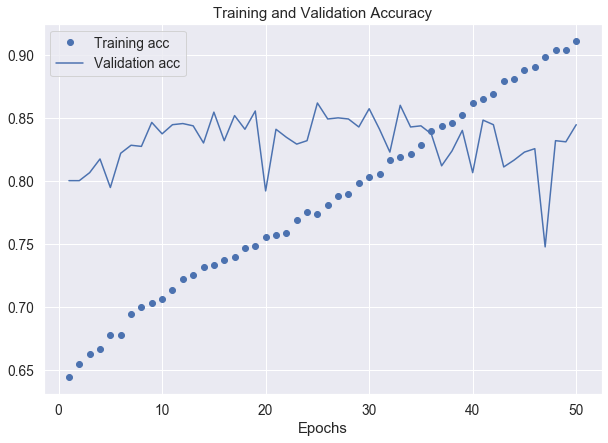

<Figure size 432x288 with 0 Axes>

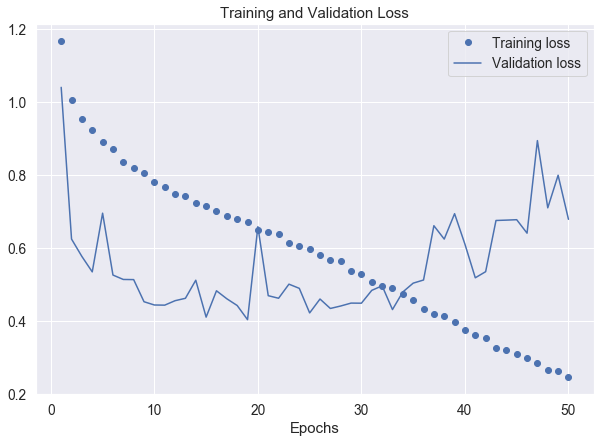

<Figure size 432x288 with 0 Axes>

In [205]:
fig = plt.figure(figsize=(10, 15))

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2,1,1)
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
fig1 = plt.figure()
fig1.savefig('train_val_acc_s.png')

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show();
fig.savefig('train_val_loss_s.png')

## Model Validation: Confusion Matrix

In [206]:
y_predict_s = model.predict(validation_images)

y_predict_classes_s = np.argmax(y_predict_s,axis = 1)
y_true = np.argmax(y_validation_s,axis = 1) 
cm_1 = confusion_matrix(y_true,y_predict_classes_s)
cm_1

array([[  6,   9,   5,   1,   3,   6,   0],
       [  1,  23,   3,   0,   2,   4,   2],
       [  3,   9,  37,   1,   8,  30,   0],
       [  0,   2,   3,   1,   0,   2,   0],
       [  4,   2,   6,   0,  18,  16,   0],
       [  6,   6,  12,   1,  20, 836,   2],
       [  0,   0,   0,   0,   0,   2,  11]])

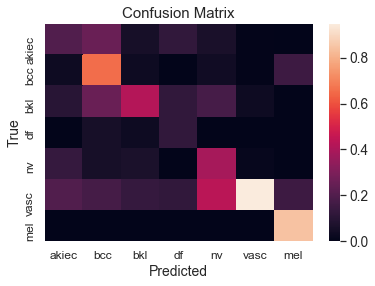

In [207]:
ax= plt.subplot()
sns.heatmap(cm_1 / cm_1.astype(np.float).sum(axis=1), annot=False, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted', size=14);
ax.set_ylabel('True', size=14); 
ax.set_title('Confusion Matrix', size=15); 
ax.xaxis.set_ticklabels(['akiec','bcc','bkl','df','nv','vasc','mel'], size=12); \
ax.yaxis.set_ticklabels(['akiec','bcc','bkl','df','nv','vasc','mel'],size=12);

In [208]:
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_predict_classes_s, average='weighted')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

precision: 0.8393080781723388
recall: 0.8449682683590208
fscore: 0.840178946950353


## Start on Transfer Learning Model (VGG16)

In [230]:
# Freeze layers and compress the flattened layer to avoid problems

input_tensor = layers.Input(shape=(224, 224,3))
vgg16 = VGG16(weights='imagenet')

output = vgg16.layers[-1].output
#output = layers.Flatten()(output)
vgg16 = models.Model(vgg16.input, output)

for layer in vgg16.layers:
    layer.trainable = False

vgg16.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [231]:
# Look at which layers are froze and not trainable

pd.set_option('max_colwidth', -1)
trainable = [(layer, layer.name, layer.trainable) for layer in vgg16.layers]
pd.DataFrame(trainable, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).head()

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x1644d04f0>,input_16,False
1,<keras.layers.convolutional.Conv2D object at 0x1644d0460>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x1644d02b0>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x1644d0340>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x1644d0c40>,block2_conv1,False


In [235]:
# Build a simple vgg transfer learning model

model_vgg = models.Sequential()
model_vgg.add(vgg16)
model_vgg.add(layers.Dense(126, activation='relu', input_dim=vgg16.output_shape[1]))
model_vgg.add(layers.Dense(1, activation='softmax'))

model_vgg.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [236]:
model_vgg.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 1000)              138357544 
_________________________________________________________________
dense_122 (Dense)            (None, 126)               126126    
_________________________________________________________________
dense_123 (Dense)            (None, 1)                 127       
Total params: 138,483,797
Trainable params: 126,253
Non-trainable params: 138,357,544
_________________________________________________________________


I decided to stop here because I was running into fit issues at the end. I wrote more about transfer learning in my blog, which you can find on my Github.

In [245]:
# vgg_history = model_vgg.fit_generator(train_generator,
#                                steps_per_epoch=163,
#                                epochs=10,
#                                validation_data=validation_generator)

## Conclusion

- Overall model accuracy reached 91% upon 50 epochs
- Our precision score for the deep learning CNN turned out to be 0.8393080781723388; this suggests that either the CNN did not pick up enough of the true positives to be effective
- Our recall score for the deep learning CNN turned out to be 0.8449682683590208; this suggests that there was a slight bloat in false positives among some of the classes.
- These could be caused by the class imbalance that existed between the training and validation sets. 
### A few options for future improvements:
  * Establish a true test set
  * Generate a way of making the classes less imbalanaced
  * Focuse on the classification of one or two different types of melanomas, then use this model for VGG transfer learning on a greater variety as scaled (I started to do this but ran into dimensional problems in the end)